# A Monte Carlo Event Generator for $e^+ e^- \rightarrow \mu^+ \mu^-$

The differential cross section for the process $e^+ e^- \rightarrow \gamma \rightarrow \mu^+ \mu^-$ is given by: 

$\frac{\mathrm{d}\sigma}{\mathrm{d} \Omega} = \frac{ \alpha^2 } { 4s} (1+ \cos^2\theta)$,

where $\alpha = e^2/(4\pi)$ is the QED running coupling. 

Since the expression does not depend on the angle $\phi$, we may integrate over it, introducing a multiplicative factor of $2\pi$ on the right-hand side. 

The integration to obtain the cross section is in fact trivial, since we know how to integrate cosine functions analytically, and the $e^+ e^-$ center-of-mass energy squared, $s$  is fixed. The total cross section in this case is given by: 

$\sigma = \frac{ 4 \pi \alpha^2 } { 3 s}$.

As a reminder, the conversion factor from GeV to pb is given by: $3.894 \times 10^8 ~\mathrm{pb/GeV}^{−2}$. 

Despite the fact that this exaple is rather easy to handle analytically, we wish begin our venture into event generation with this simple exercise, as it provides an insight to the basic building blocks of an event generator. 

Let's first calculate the *total cross section* analytically, using the integration routines that we have developed thus far. 

import Let's start by copying the MC integration routine, which also finds the maximum. 

In [1]:
import random
import math

# Let's define a function that performs one-dimensional MC integration of an arbitrary for N points
# We'll also make it capable of performing the integration in an interval a,b
def mcint(func, a, b, N):
    """Calculates the one-dimensional Monte Carlo integral of func in [a,b] for N points"""
    sumw = 0 # we will use this variable for the sum of f(x_i)
    sumwsq = 0 # and this one for the sum of f(x_i)^2, used in the error calculation
    maxw = -1E99 # the maximum weight found during the integration
    xmaxw = -1E99 # the location of the maximum weight 
    for i in range(int(N)):
        xi = (b-a) * random.random() + a
        wi = (b-a)*func(xi)
        sumw += wi
        sumwsq += wi**2 
        if wi > maxw:
            maxw = wi
            xmaxw = xi
    # now calculate the average value of f (i.e. the integral):
    I = sumw/N
    # and the error: 
    sigmaIsq = (1/N) * ( (1/N) * sumwsq - I**2 ) # this is the variance (i.e. the error squared)
    sigmaI = math.sqrt(sigmaIsq) # this is the actual error
    return I, sigmaI, maxw, xmaxw # return the integral and its error and the maximum weight and its location

Let's define the function we wish to integrate, i.e. the differential cross section: 

In [2]:
# conversion factor from GeV^-2 to pb:
pbconvert=3.894E8
# this is the QED running coupling at 90 GeV:
alpha = 1/132.507 

# Now let's also define the function that we wish to integrate:
def f(x,s=30**2): # x = costheta, and set the COM energy to 90 GeV
    return 2*math.pi*((alpha**2)/(4 * s))*(1+x**2)

And integrate! 

In [3]:
# fix the COM energy globally
ECM = 30 # in GeV
s=ECM**2

# Use the function again to get the integral and the maximum weight: 
N = 100000 # with 10000 points we expect O(1/sqrt(N)) ~ O(1%) error
Int, Err, MaxW, xMaxW = mcint(f,-1,1,N) # this way you can access both the integral and its error
print('The cross section in pb is:', Int*pbconvert, '+-', Err*pbconvert)
print('Maximum weight found=', MaxW, 'at', xMaxW)

The cross section in pb is: 103.18977699060467 +- 0.07284742751739418
Maximum weight found= 3.9761098803460506e-07 at -0.9999969187100148


Let's also calculate the analytical expectation for the total cross section:

In [4]:
# analytical expression for the cross section for e+e- -> gamma -> mu+mu-
def sigma_analytical():
    return 4 * math.pi * alpha**2 / 3 / s 

sigma_analyt = sigma_analytical() 
sigma_analytical_pb = sigma_analyt*pbconvert
print("The analytical cross sectin for e+e- -> gamma -> mu+mu- at 30 GeV is", sigma_analytical_pb)

The analytical cross sectin for e+e- -> gamma -> mu+mu- at 30 GeV is 103.22013054444798


Evidently these two are compatible! 

We are now ready to proceed to the event generation stage. This will consist simply of generating the $\cos \theta$ values and then "reconstructing" the momenta according to those values, for each event. The angle $\phi$ can be chosen uniformly and randomly in the interval $(0,2 \pi$). Let's start by generating a list of $\cos \theta$, distributed according to our differential cross section. This list is essentially the list of events. 

Let's use the ```evtgen``` function from the introduction to this section! 

In [5]:
# event generation function according to func, given the number of events to be generated Ngen in the interval a, b,
# and number of integration events Nint
def evtgen(func, a, b, Ngen, Nint):
    # first find the integral using the integration function: 
    Int, Err, wmax, xwmax = mcint(func,a,b,Nint) 
    # define a counter to check when to terminate the event generation:
    counter = 0
    # an empty list to hold the Ngen events
    eventslist = []
    while counter < Ngen:
        # get a random point and calculate its weight: 
        xi = (b-a) * random.random() + a
        wi = (b-a)*func(xi)
        if wi/wmax > random.random():
            # accept the event, increment counter
            eventslist.append(xi)    
            counter += 1
        else:
            # reject the event and check another one
            continue 
    # return the integral, the eror and the events list
    return Int, Err, eventslist

In [6]:
# integral number of points:
Nintegral = 100000
# number of events to be generated: 
Nevents = 10000
sigma, sigmaerr, events = evtgen(f,-1,1,Nevents,Nintegral)

# check that the number of events generated is as requested:
print('Number of events generated=', len(events))

Number of events generated= 10000


Let's check whether it corresponds to what we expect! In this case we actually can also plot the analytical form, as we did in the introduction. 

In [7]:
import matplotlib.pyplot as plt # import matplotlib, a conventional module name is plt
import numpy as np

fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

# set the labels and titles:
ax.set_xlabel(r'$\cos\theta$', fontsize=20) # set the x label
ax.set_ylabel(r'frequency', fontsize=20) # set the y label
ax.set_title(r'Differential cross section for $e^+ e^- \rightarrow \gamma \rightarrow \mu^+ \mu^-$', fontsize=10) # set the title 

# make one-dimensional plots using the above arrays, add a custom label, linestyles and colors:
ax.hist(events, color='blue', bins=25, density=True, fill=False, histtype='step', label="hit-or-miss") 

# plot the distribution itself:
xv = np.linspace(-1, 1,1000)
analytic = f(xv) / sigma_analyt# pi/2 is the analytic integral 

ax.plot(xv, analytic, ls='--', color='red', label='analytic')

# construct the legend:
ax.legend(loc='upper right')  # Add a legend

plt.show() # show the plot here

ModuleNotFoundError: No module named 'matplotlib'

Therefore, our events have indeed the right distribution: they follow the differential cross section, as expected! 

Let's now proceed to set up the momenta of the particles in each event. This is relatively easy in this case, since we are actually working directly in the center of mass frame. 

If we assume that the incoming beans are traveling in the positive and negative $z$-directions, e.g. $e^-$ in the positive and $e^+$ in the negative, then the incoming particle four-momenta can be written as: 

$p_{e^-} = \frac{\sqrt{s}}{2} ( 1, 0, 0, 1)$,

$p_{e^+} = \frac{\sqrt{s}}{2} ( 1, 0, 0, -1)$,

and the outgoing four-momenta according to the generated $(\theta, \phi)$:

$p_{\mu^-} = \frac{\sqrt{s}}{2} ( 1, \sin \theta \cos \phi, \sin \theta \sin\phi, \cos\theta)$, 

$p_{\mu^+} = \frac{\sqrt{s}}{2} ( 1, -\sin \theta \cos \phi, -\sin \theta \sin\phi, -\cos\theta)$,

where one can clearly observe that energy and momentum are conserved. 

Let's now "reconstruct" (i.e. build) the four-vectors in each event according to the list of $\cos \theta$ that we have generated. 

In [49]:
# takes a list of cos thetas and reconstructs the four-momenta
# for the process e- e+ -> mu- mu+ in the COM
# returns a list of four-vectors, where a four-vector is a list of four numbers
def reconstruct(costhetas):
    recoevents = []
    sqrtso2 = math.sqrt(s)/2 # appears often so no need to recalc.
    for costh in costhetas:
        # generate a random phi:
        phi = random.random()*2*math.pi
        # get sintheta as well:
        sinth = math.sqrt(1-costh**2)
        pem = [sqrtso2, 0, 0, sqrtso2]
        pep = [sqrtso2, 0, 0, -sqrtso2]
        pmm = [sqrtso2, sqrtso2*sinth * math.cos(phi), sqrtso2*sinth * math.sin(phi), sqrtso2*costh]
        pmp = [sqrtso2, -sqrtso2*sinth * math.cos(phi), -sqrtso2*sinth * math.sin(phi), sqrtso2*costh]
        recoevents.append([pem, pep, pmm, pmp])
    return recoevents

# get the reconstructed events: 
reconstructed_events = reconstruct(events)
    

Let's see an example of an event, e.g. the first one:

In [50]:
for p in reconstructed_events[0]:
    print('p=',p)

p= [15.0, 0, 0, 15.0]
p= [15.0, 0, 0, -15.0]
p= [15.0, -3.7595365564146843, -3.12158419981338, -14.181734624666232]
p= [15.0, 3.7595365564146843, 3.12158419981338, -14.181734624666232]


Seems pretty reasonable! 

Since there is effectively only one degree of freedom, there's not many variables that are interesting in this simple case. We can imagine reconstructing the ``transverse momentum'', the magnitude of the momentum in the $x$ and $y$ directions, defined as:

$p_T = \sqrt{p_x^2 + p_y^2}$ 

Let's calculate this per event for the outgoing $\mu^-$ and plot it! 

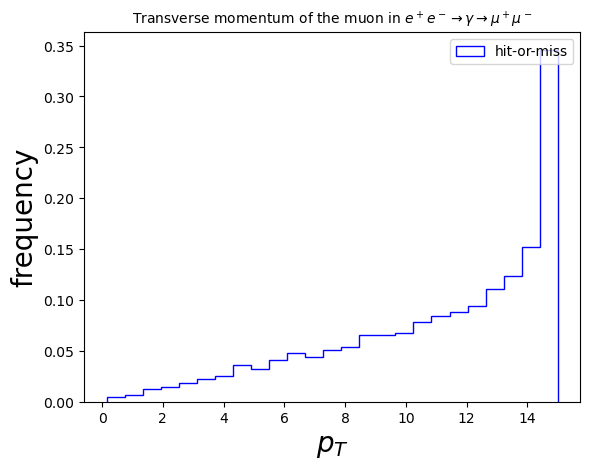

In [51]:
pT_list = [] # the list that will contain all the transverse momenta
for ev in reconstructed_events:
    pmm = ev[2] # the mu- is the third entry in the event in this case
    pT = math.sqrt(pmm[1]**2 + pmm[2]**2)
    pT_list.append(pT)

# PLOT! 
fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

# set the labels and titles:
ax.set_xlabel(r'$p_T$', fontsize=20) # set the x label
ax.set_ylabel(r'frequency', fontsize=20) # set the y label
ax.set_title(r'Transverse momentum of the muon in $e^+ e^- \rightarrow \gamma \rightarrow \mu^+ \mu^-$', fontsize=10) # set the title 

# make one-dimensional plots using the above arrays, add a custom label, linestyles and colors:
ax.hist(pT_list, color='blue', bins=25, density=True, fill=False, histtype='step', label="hit-or-miss") 

# construct the legend:
ax.legend(loc='upper right')  # Add a legend

plt.show() # show the plot here

An interesting next step is to consider the full process for $e^+ e^- \rightarrow \mu^+ \mu^-$, which includes a contribution from the $Z$ boson. The main difference in the way that the $Z$ boson interacts with the leptons is that it couples with different strengths to the left- and right-handed fermions. 

See the details discussed in secton 3.1.2 of https://arxiv.org/pdf/1412.4677. Following these, you should be able to address section 3.2, Exercise 1. 